In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification
from transformers import BertModel
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

/home/rjn/.conda/envs/main_env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/rjn/.conda/envs/main_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

from sklearn.utils import shuffle
df = pd.read_csv(
    'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/Dataset/ecommerceDataset.csv', 
    names = ['label', 'description']
)
df = df[['description', 'label']]

df.drop_duplicates(inplace = True) 

df = df.dropna(subset=['description'])

df.reset_index(drop = True, inplace = True)

df = shuffle(df)

df = df[0:100]

In [3]:
from transformers import BertTokenizer
from torch.utils.data import random_split


class TensorDataLoader(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

class PrepareDataset:
    
    def __init__(self, dataframe, text_column_name : str, labels_column_name: str, encoding : bool = False, split : float = 0.75) -> None:
        self.df = dataframe
        
        self.text_column_name = text_column_name
        self.labels_column_name = labels_column_name
        
        if encoding:
            self.convert_label()
            
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        
        self.split = split
        
        self.unique_labels = self.df[self.labels_column_name].nunique()
    
    def convert_label(self):
        unique = self.df[self.labels_column_name].unique()
        map_value = {v: i for i, v in enumerate(unique)}
        self.df[f"{self.labels_column_name}"] = self.df[self.labels_column_name].map(map_value)


    def get_input_id_attention_mask(self, sentence):
        tokens = self.tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )
    
        return tokens['input_ids'].squeeze(), tokens['attention_mask'].squeeze()
    
    
    def get_data_loader(self):
        
        ids = torch.zeros(((len(df), 512)), dtype=torch.long)
        masks = torch.zeros(((len(df), 512)), dtype=torch.long)

        # Iterate over each text in the 'text' column of the DataFrame
        for i, txt in enumerate(self.df[self.text_column_name]):
            # Tokenize the current text using the tokenize function
            input_ids, attention_masks = self.get_input_id_attention_mask(txt)
            
            # Assign the tokenized input IDs to the corresponding row in the ids tensor
            ids[i,:]=input_ids
            
            # Assign the attention masks to the corresponding row in the masks tensor
            masks[i,:]=attention_masks
            
        arr = df[self.labels_column_name].values
        labels = torch.zeros((arr.size, arr.max()+1), dtype=torch.float)
        labels[torch.arange(arr.size), arr] = 1
        
        dataset = TensorDataLoader(ids, masks, labels)
        
        train_size = int(len(dataset) * self.split)
        test_size = len(dataset) - train_size

        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
        
        return train_dataset, test_dataset

In [4]:
bert_data_loader = PrepareDataset(dataframe=df,
                                  text_column_name="description",
                                  labels_column_name="label",
                                  encoding=True)

In [5]:
train_dataset, test_dataset = bert_data_loader.get_data_loader()

In [6]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


# Define NN Architecture
class ClassificationModel(nn.Module):
    def __init__(self, bert, n_lables : int):
        """
        Initialize the sentiment classifier model with BERT.
        
        Parameters:
        - bert (BertModel): Pretrained BERT model.
        """
        super(ClassificationModel, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p=0.25)
        self.fc = nn.Linear(bert.config.hidden_size, n_lables)
        
    def forward(self, input_ids, attention_mask):
        """
        Forward pass for the sentiment classifier.
        
        Parameters:
        - input_ids (torch.Tensor): Input IDs tensor.
        - attention_mask (torch.Tensor): Attention mask tensor.
        
        Returns:
        - torch.Tensor: Output logits.
        """
        # Pass the inputs through the BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use the pooled output from BERT
        pooled_output = outputs.pooler_output
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Pass through the fully connected layer to get logits
        logits = self.fc(pooled_output)
        
        return logits

In [8]:
# Initialize Bert Architecture
bert = BertModel.from_pretrained('bert-base-cased')

# Initialize NN Architecture
BertClassifier = ClassificationModel(bert,bert_data_loader.unique_labels)

# set the unfreeze layer 10 or layer 11
for name, param in BertClassifier.bert.named_parameters():
    if 'layer.11' in name or 'layer.10' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# if multiple devices, convert the model into model parallel.
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    BertClassifier = nn.DataParallel(BertClassifier)
    
else:
    # if not, just convert the model into device
    BertClassifier.to(device)

Device: cuda


In [9]:
from transformers import AdamW, get_linear_schedule_with_warmup

#No of Epochs
epochs = 15

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, BertClassifier.parameters()), lr=2e-5)

# Define Scheduler with total seteps 
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/home/rjn/.conda/envs/main_env/lib/python3.12/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []

all_epoch_preds, all_epoch_labels = [], []

for epoch in range(epochs):
    # Set the model to training mode
    BertClassifier.train()
    total_loss, total_correct = 0, 0
    total_samples = 0  # Initialize total samples for train

    # Create a progress bar for the training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    # Iterate over the training batches
    for i, batch in enumerate(train_loader_tqdm):
        # Zero the gradients
        optimizer.zero_grad()

        # Move the batch data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(labels, dim=1)

        # Forward pass through the model
        outputs = BertClassifier(input_ids, attention_mask)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backpropagate the gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Update the total loss, correct predictions, and total samples
        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_samples += len(batch["input_ids"])

        # Update the progress bar with the current loss and accuracy
        train_loader_tqdm.set_postfix({"loss": f"{loss.item():.4f}",
                                        "acc": f"{(outputs.argmax(dim=1) == labels).float().mean().item() * 100:.2f}%"})

    # Update the learning rate scheduler
    scheduler.step()

    # Calculate the average training loss and accuracy
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_correct / total_samples

    # Append the training loss and accuracy to the lists
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)

    # Print the training loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc * 100:.2f}%")

    # Set the model to evaluation mode
    BertClassifier.eval()
    total_test_loss, total_test_correct = 0, 0
    total_test_samples = 0  # Initialize total samples for test
    all_preds = []
    all_labels = []

    # Create a progress bar for the test loop
    test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    # Disable gradient calculation for the test loop
    with torch.no_grad():
        # Iterate over the test batches
        for i, batch in enumerate(test_loader_tqdm):
            # Move the batch data to the device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            # Forward pass through the model
            outputs = BertClassifier(input_ids, attention_mask)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Update the total validation loss, correct predictions, and total samples
            total_test_loss += loss.item()
            total_test_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_test_samples += len(batch["input_ids"])

            # Collect predictions and true labels
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update the progress bar with the current validation loss and accuracy
            test_loader_tqdm.set_postfix({"loss": f"{loss.item():.4f}",
                                           "acc": f"{(outputs.argmax(dim=1) == labels).float().mean().item() * 100:.2f}%"})

    # Calculate the average validation loss and accuracy
    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_acc = total_test_correct / total_test_samples

    # Append the validation loss and accuracy to the lists
    test_loss.append(avg_test_loss)
    test_acc.append(avg_test_acc)

    # Append epoch predictions and labels to the lists
    all_epoch_preds.extend(all_preds)
    all_epoch_labels.extend(all_labels)

    # Print the validation loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc * 100:.2f}%")

Epoch 1/15: 100%|██████████| 3/3 [00:15<00:00,  5.27s/batch, loss=1.3628, acc=36.36%]


Epoch 1/15, Training Loss: 1.4031, Training Accuracy: 25.33%


Epoch 1/15: 100%|██████████| 1/1 [00:03<00:00,  3.85s/batch, loss=1.4916, acc=16.00%]


Epoch 1/15, Test Loss: 1.4916, Test Accuracy: 16.00%


Epoch 2/15: 100%|██████████| 3/3 [00:15<00:00,  5.16s/batch, loss=1.5167, acc=18.18%]


Epoch 2/15, Training Loss: 1.4660, Training Accuracy: 18.67%


Epoch 2/15: 100%|██████████| 1/1 [00:03<00:00,  3.89s/batch, loss=1.4656, acc=16.00%]


Epoch 2/15, Test Loss: 1.4656, Test Accuracy: 16.00%


Epoch 3/15: 100%|██████████| 3/3 [00:15<00:00,  5.17s/batch, loss=1.4387, acc=27.27%]


Epoch 3/15, Training Loss: 1.3756, Training Accuracy: 28.00%


Epoch 3/15: 100%|██████████| 1/1 [00:03<00:00,  3.90s/batch, loss=1.4445, acc=28.00%]


Epoch 3/15, Test Loss: 1.4445, Test Accuracy: 28.00%


Epoch 4/15: 100%|██████████| 3/3 [00:15<00:00,  5.19s/batch, loss=1.2449, acc=54.55%]


Epoch 4/15, Training Loss: 1.3489, Training Accuracy: 36.00%


Epoch 4/15: 100%|██████████| 1/1 [00:03<00:00,  3.85s/batch, loss=1.4219, acc=24.00%]


Epoch 4/15, Test Loss: 1.4219, Test Accuracy: 24.00%


Epoch 5/15: 100%|██████████| 3/3 [00:15<00:00,  5.18s/batch, loss=1.1893, acc=54.55%]


Epoch 5/15, Training Loss: 1.2887, Training Accuracy: 33.33%


Epoch 5/15: 100%|██████████| 1/1 [00:03<00:00,  3.88s/batch, loss=1.4051, acc=32.00%]


Epoch 5/15, Test Loss: 1.4051, Test Accuracy: 32.00%


Epoch 6/15: 100%|██████████| 3/3 [00:15<00:00,  5.19s/batch, loss=1.2639, acc=45.45%]


Epoch 6/15, Training Loss: 1.2992, Training Accuracy: 41.33%


Epoch 6/15: 100%|██████████| 1/1 [00:03<00:00,  3.88s/batch, loss=1.3899, acc=32.00%]


Epoch 6/15, Test Loss: 1.3899, Test Accuracy: 32.00%


Epoch 7/15: 100%|██████████| 3/3 [00:15<00:00,  5.20s/batch, loss=1.1377, acc=54.55%]


Epoch 7/15, Training Loss: 1.2606, Training Accuracy: 45.33%


Epoch 7/15: 100%|██████████| 1/1 [00:03<00:00,  3.88s/batch, loss=1.3772, acc=36.00%]


Epoch 7/15, Test Loss: 1.3772, Test Accuracy: 36.00%


Epoch 8/15: 100%|██████████| 3/3 [00:15<00:00,  5.16s/batch, loss=1.3250, acc=18.18%]


Epoch 8/15, Training Loss: 1.3167, Training Accuracy: 37.33%


Epoch 8/15: 100%|██████████| 1/1 [00:03<00:00,  3.85s/batch, loss=1.3673, acc=36.00%]


Epoch 8/15, Test Loss: 1.3673, Test Accuracy: 36.00%


Epoch 9/15: 100%|██████████| 3/3 [00:15<00:00,  5.17s/batch, loss=1.0523, acc=90.91%]


Epoch 9/15, Training Loss: 1.2271, Training Accuracy: 44.00%


Epoch 9/15: 100%|██████████| 1/1 [00:03<00:00,  3.92s/batch, loss=1.3594, acc=40.00%]


Epoch 9/15, Test Loss: 1.3594, Test Accuracy: 40.00%


Epoch 10/15: 100%|██████████| 3/3 [00:15<00:00,  5.17s/batch, loss=1.2010, acc=54.55%]


Epoch 10/15, Training Loss: 1.2693, Training Accuracy: 38.67%


Epoch 10/15: 100%|██████████| 1/1 [00:03<00:00,  3.89s/batch, loss=1.3510, acc=36.00%]


Epoch 10/15, Test Loss: 1.3510, Test Accuracy: 36.00%


Epoch 11/15: 100%|██████████| 3/3 [00:15<00:00,  5.17s/batch, loss=1.3705, acc=36.36%]


Epoch 11/15, Training Loss: 1.3480, Training Accuracy: 34.67%


Epoch 11/15: 100%|██████████| 1/1 [00:03<00:00,  3.87s/batch, loss=1.3406, acc=32.00%]


Epoch 11/15, Test Loss: 1.3406, Test Accuracy: 32.00%


Epoch 12/15: 100%|██████████| 3/3 [00:15<00:00,  5.18s/batch, loss=1.2498, acc=36.36%]


Epoch 12/15, Training Loss: 1.2784, Training Accuracy: 38.67%


Epoch 12/15: 100%|██████████| 1/1 [00:03<00:00,  3.88s/batch, loss=1.3297, acc=32.00%]


Epoch 12/15, Test Loss: 1.3297, Test Accuracy: 32.00%


Epoch 13/15: 100%|██████████| 3/3 [00:15<00:00,  5.17s/batch, loss=1.1168, acc=72.73%]


Epoch 13/15, Training Loss: 1.2199, Training Accuracy: 46.67%


Epoch 13/15: 100%|██████████| 1/1 [00:03<00:00,  3.88s/batch, loss=1.3183, acc=36.00%]


Epoch 13/15, Test Loss: 1.3183, Test Accuracy: 36.00%


Epoch 14/15: 100%|██████████| 3/3 [00:15<00:00,  5.18s/batch, loss=1.3645, acc=9.09%] 


Epoch 14/15, Training Loss: 1.2636, Training Accuracy: 38.67%


Epoch 14/15: 100%|██████████| 1/1 [00:03<00:00,  3.86s/batch, loss=1.3066, acc=36.00%]


Epoch 14/15, Test Loss: 1.3066, Test Accuracy: 36.00%


Epoch 15/15: 100%|██████████| 3/3 [03:03<00:00, 61.01s/batch, loss=1.3036, acc=27.27%] 


Epoch 15/15, Training Loss: 1.2197, Training Accuracy: 49.33%


Epoch 15/15: 100%|██████████| 1/1 [00:03<00:00,  3.84s/batch, loss=1.2954, acc=36.00%]

Epoch 15/15, Test Loss: 1.2954, Test Accuracy: 36.00%


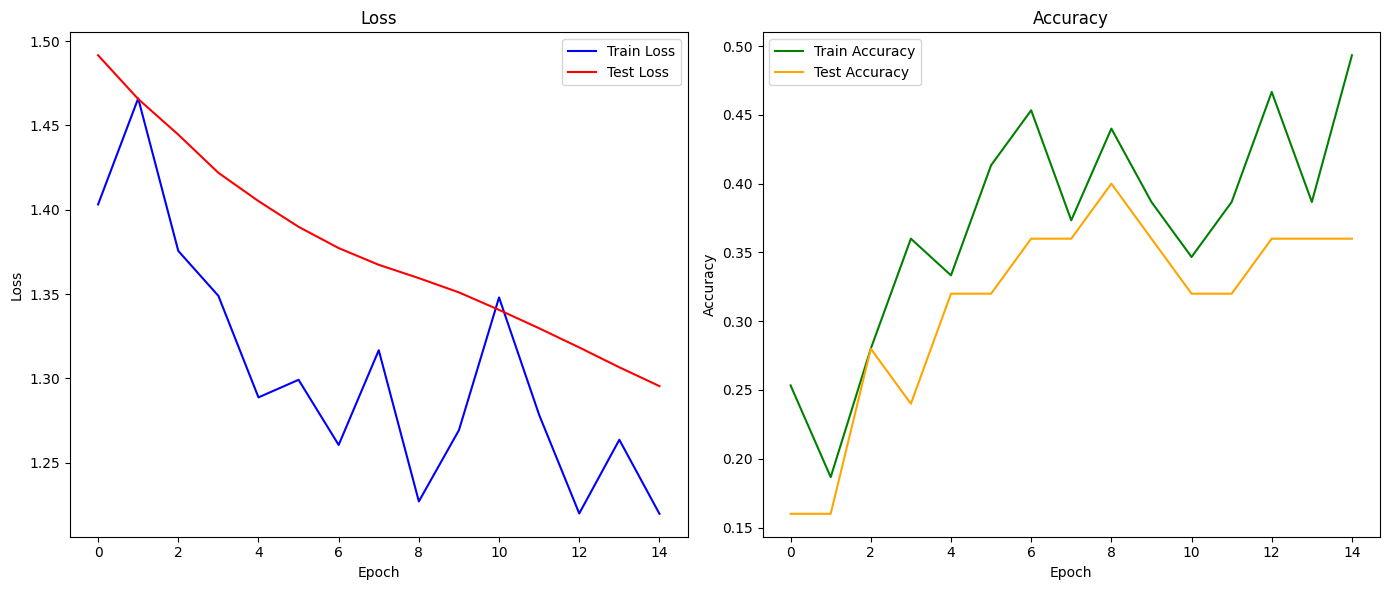

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(train_loss, label='Train Loss', color='blue')
ax1.plot(test_loss, label='Test Loss', color='red')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting train and test accuracy on the second subplot
ax2.plot(train_acc, label='Train Accuracy', color='green')
ax2.plot(test_acc, label='Test Accuracy', color='orange')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [11]:
# Create a DataFrame for all epoch predictions and true labels
df_results = pd.DataFrame({"Predictions": all_epoch_preds, "True Labels": all_epoch_labels})
print(df_results.head())  # Print the first few rows of the DataFrame

# Save the DataFrame to a CSV file (optional)
df_results.to_csv('predictions_vs_true_labels.csv', index=False)

   Predictions  True Labels
0            1            0
1            2            0
2            1            2
3            2            0
4            2            3


              precision    recall  f1-score   support

           0       0.39      0.55      0.46       165
           1       0.13      0.22      0.16        45
           2       0.25      0.27      0.26        60
           3       0.00      0.00      0.00       105

    accuracy                           0.31       375
   macro avg       0.19      0.26      0.22       375
weighted avg       0.23      0.31      0.26       375



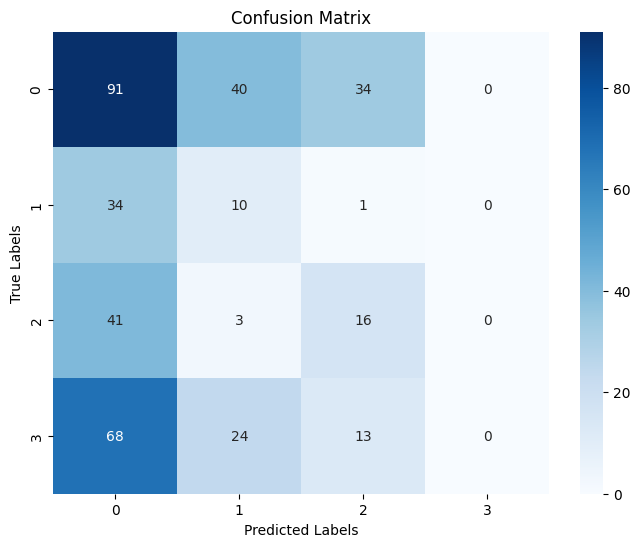

In [17]:
import warnings 
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


# Extract predictions and true labels
y_pred = df_results['Predictions']
y_true = df_results['True Labels']

# Generate classification report
report = classification_report(y_true, y_pred)

print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
